# Predição de divócios

O dataset que vai ser trabalhado consiste em várias questões (`Q1`, `Q2`, ..., `Q53`, `Q54`) de pontuação de `0` à `4`, que foram feitas à casais "felizes" ou divorciados (que é indicado pela coluna `Divorce`, sendo 0 o valor para não divorciados e 1 para os já divorciados).

A Árvore (ou Floresta) de decisão será usada aqui para tentar predizer se, de acordo com as respostas das questões, um casal está propenso a se divorciar ou não.

As questões do dataset e mais detalhes estão disponíveis em: https://www.kaggle.com/andrewmvd/divorce-prediction


In [1]:
# import de bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

## Importação e análise inicial dos dados

In [2]:
# leitura, armazenamento do dataframe
# o dataframe já está bem limpo, não vai ser preciso fazer nenhum trabalho nele nesse sentido

dataframe = pd.read_csv('./semana02_dataset/divorce_data.csv')

# breve overview sobre o dataset
dataframe.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54,Divorce
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,...,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,1.776471,1.652941,1.764706,1.482353,1.541176,0.747059,0.494118,1.452941,1.458824,1.576471,...,2.552941,2.270588,2.741176,2.382353,2.429412,2.476471,2.517647,2.241176,2.011765,0.494118
std,1.627257,1.468654,1.415444,1.504327,1.632169,0.904046,0.898698,1.546371,1.557976,1.421529,...,1.371786,1.586841,1.137348,1.511587,1.405090,1.260238,1.476537,1.505634,1.667611,0.501442
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,...,3.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,2.000000,0.000000
75%,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000


In [3]:
# para visualizar melhor as correlações entre das colunas e os divócios
# o np.abs serve para normalizar tudo em escala positiva
# o sort_values é para organizar da maior para a menor correlação

# isso pode ser usado para decidir quais parametros tirar na tentativa de deixar a arvore de decisão mais concisa
dataframe.corr()['Divorce'].apply(np.abs).sort_values(ascending=False)

Divorce    1.000000
Q40        0.938684
Q17        0.929346
Q19        0.928627
Q18        0.923208
Q11        0.918386
Q9         0.912368
Q20        0.907008
Q15        0.901220
Q39        0.896180
Q41        0.894356
Q5         0.893180
Q29        0.892954
Q36        0.886497
Q16        0.886260
Q38        0.883311
Q30        0.874531
Q26        0.872868
Q27        0.869788
Q8         0.869569
Q12        0.868983
Q21        0.864519
Q14        0.864316
Q37        0.863597
Q35        0.862624
Q33        0.861328
Q1         0.861324
Q25        0.857052
Q44        0.847336
Q28        0.846606
Q13        0.844743
Q24        0.839392
Q23        0.837504
Q34        0.835167
Q10        0.834897
Q32        0.829056
Q22        0.825938
Q2         0.820774
Q4         0.819583
Q54        0.806765
Q3         0.806709
Q31        0.792607
Q50        0.755248
Q49        0.740704
Q42        0.739629
Q53        0.711176
Q51        0.692681
Q47        0.656409
Q52        0.651478
Q48        0.619830


## Preparação dos dados para uso nos treinos e testes

In [4]:
# as questões
x = dataframe.iloc[:,0:-1]

# a informação se o casal é divorciado ou não
y = dataframe.iloc[:,-1]


## Árvoce de decisão simples
Utilizando uma separação básica dos dados de treino e teste

In [5]:
# separação dos dados para treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q45,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54
15,4,4,3,2,4,0,0,4,3,2,...,4,4,4,4,4,4,4,4,4,4
73,4,3,3,3,3,1,4,0,4,3,...,3,3,3,3,3,3,3,3,3,3
71,2,2,3,2,2,2,2,2,3,2,...,4,4,4,4,4,4,4,4,4,4
144,0,0,2,4,0,0,0,0,0,2,...,3,2,0,2,4,0,0,1,0,0
87,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,1,2,2,1


In [6]:
# definindo e treinando a arvore de decisão com os dados de treino

classificator = DecisionTreeClassifier()
classificator.fit(x_train, y_train)

DecisionTreeClassifier()

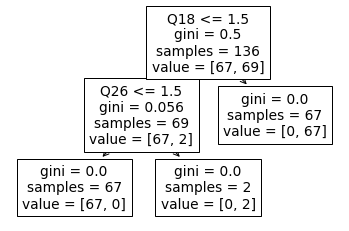

In [7]:
plot_tree(classificator, feature_names=dataframe.columns[0:-1])
plt.show()

In [8]:
# testando os resultados do classificador
classification = classificator.predict(x_test)
classification

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0])

In [9]:
accuracy = accuracy_score(y_test, classification)
accuracy

0.9705882352941176

In [10]:
precision = precision_score(y_test, classification)
precision

1.0

In [11]:
recall = recall_score(y_test, classification)
recall

0.9333333333333333

In [12]:
f1 = f1_score(y_test, classification)
f1


0.9655172413793104

In [13]:
fpr, tpr, _ = roc_curve(y_test, classification)

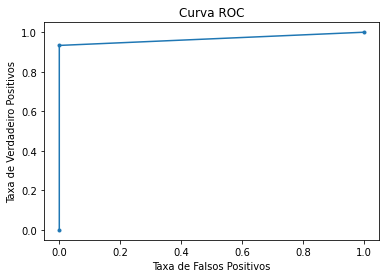

In [14]:
plt.plot(fpr,tpr,marker='.')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiro Positivos')
plt.show()

In [15]:
# a taxa de verdadeiros positivos está ótima

# agora a representação numérica da área abaixo da curva
auc = roc_auc_score(y_test, classification)
auc

0.9666666666666667

## Validação cruzada
Os resultados anteriores estão ótimos, mas podem não representar totalmente a realidade, então será feito treino e teste via validação cruzada para tentar dar mais confiabilidade aos resultados

In [16]:
kf = KFold(n_splits=5)

In [17]:
#calculando os scores
scores = cross_val_score(DecisionTreeClassifier(), x, y, cv=10)
scores

array([0.82352941, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.94117647, 1.        , 1.        ])

In [18]:
scores.mean()

0.9764705882352942

A precisão continua se mostrando bem alta. Isso é resultado da correlação bem presente entre as colunas do dataset.

## Utilizando uma Floresta de decisão

Agora ao invez de tentar variar nos dados de treino e teste, serão variadas às prórias árvores de decisão

In [19]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(x_train, y_train)

RandomForestClassifier()

In [20]:
# medição da precisão da floresta de decisão
forest.score(x_test, y_test)

0.9705882352941176

## Comparando a Àrvore de decisão com a Floresta de decisão

In [21]:
clf_tree = classificator.predict(x_test)
clf_tree

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0])

In [22]:
clf_forest = forest.predict(x_test)
clf_forest

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0])

In [23]:
# roc da árvore de da floresta
fpr_tree, tpr_tree, _ = roc_curve(y_test, clf_tree)
fpr_forest, tpr_forest, _ = roc_curve(y_test, clf_forest)

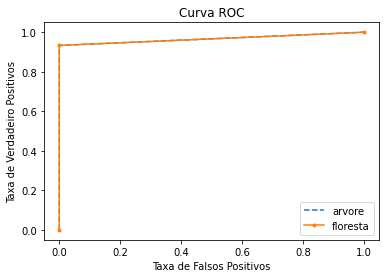

In [24]:
# plotando curvas
plt.plot(fpr_tree, tpr_tree, linestyle='--', label='arvore')
plt.plot(fpr_forest, tpr_forest, marker='.', label='floresta')
plt.title('Curva ROC')
plt.legend()
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiro Positivos')
plt.show()